In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from iso3166 import countries
import folium
from geopy.geocoders import Nominatim
from time import sleep



In [149]:
data = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [150]:
print("Basic INformation\n\n",data.info())
print()
print("Shape of the dataset:",data.shape)
print("First Data\n\n",data.head())
print()
print("Last 5 data\n\n",data.tail())
print()
print("Colunms :\n\n",data.columns)
print()
print("Basic Statictis",data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [151]:
data.isnull().sum()

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

In [159]:
data['st']=data['creation_time'].copy()
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['Duration'] = (data['end_time']- data['creation_time']).dt.total_seconds()
data['Total Bytes'] = data['bytes_in'] + data['bytes_out']
data['Packet Size'] = (data['bytes_in'] + data['bytes_out'])/data['Duration']

In [153]:
data.columns

Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types', 'st', 'Total Bytes'],
      dtype='object')

C:\Users\HP\AppData\Local\Temp\ipykernel_13152\1311554931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='src_ip', data=data,order=top_src_ips.index,palette="viridis")


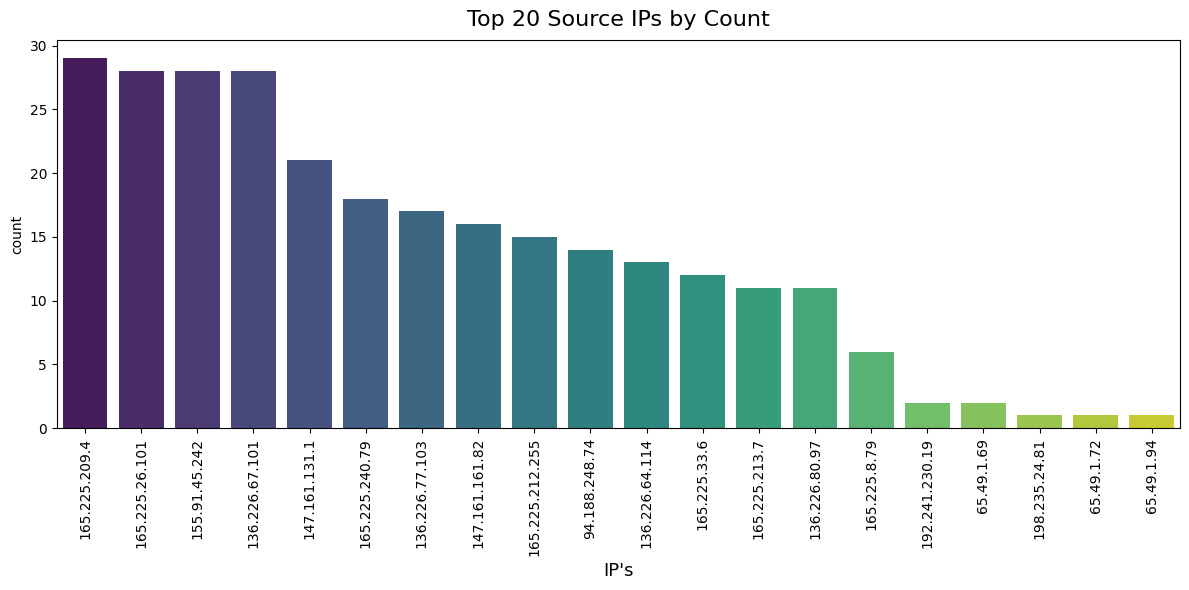

In [172]:
plt.Figure(figsize=(6,10))
top_src_ips = data['src_ip'].value_counts().head(20)  #Limit to top 20 for better visibility
# Plot
plt.figure(figsize=(12,6))
sb.countplot(x='src_ip', data=data,order=top_src_ips.index,palette="viridis")
plt.xticks(rotation=90)
plt.title('Top 20 Source IPs by Count',fontsize=16,pad=10)
plt.xlabel("IP's",fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top 20 Source IPs by Count')
plt.show()

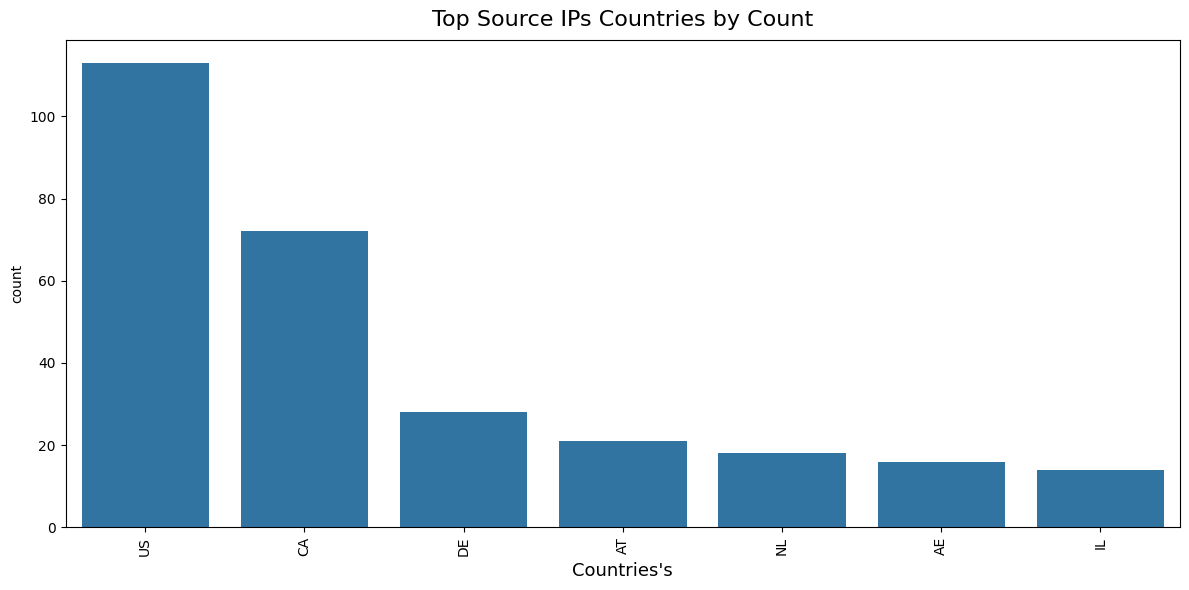

In [ ]:
plt.Figure(figsize=(6,10))
top_src_ips = data['src_ip_country_code'].value_counts() #Limit to top 20 for better visibility
# Plot
plt.figure(figsize=(12,6))
sb.countplot(data=data,x='src_ip_country_code',order=data['src_ip_country_code'].value_counts().index,palette="viridis")
plt.xticks(rotation=90)
plt.title('Top Source IPs Countries by Count',fontsize=16,pad=10)
plt.xlabel("Countries's",fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top Source IPs Countries by Count')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13152\1033109051.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(x='bytes_in', y='bytes_out', data=data,markers='--',palette="viridis")


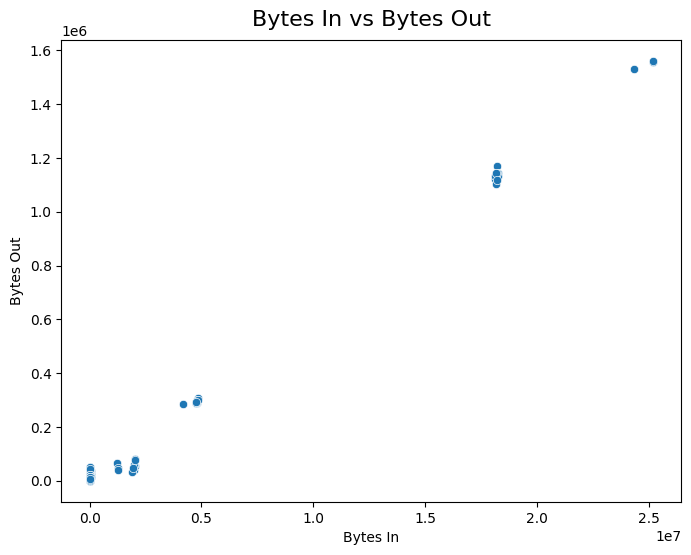

In [ ]:
# Visualize bytes_in vs bytes_out
plt.figure(figsize=(8, 6))
sb.scatterplot(x='bytes_in', y='bytes_out', data=data,markers='--')
plt.xlabel('Bytes In')
plt.ylabel('Bytes Out')
plt.title('Bytes In vs Bytes Out',fontsize=16,pad=10)

plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13152\3922583126.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.lineplot(x='st',y='bytes_in',data=data, label='Bytes In',palette="viridis")
C:\Users\HP\AppData\Local\Temp\ipykernel_13152\3922583126.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.lineplot(x='st',y='bytes_out',data=data, label='Bytes out',palette="viridis")


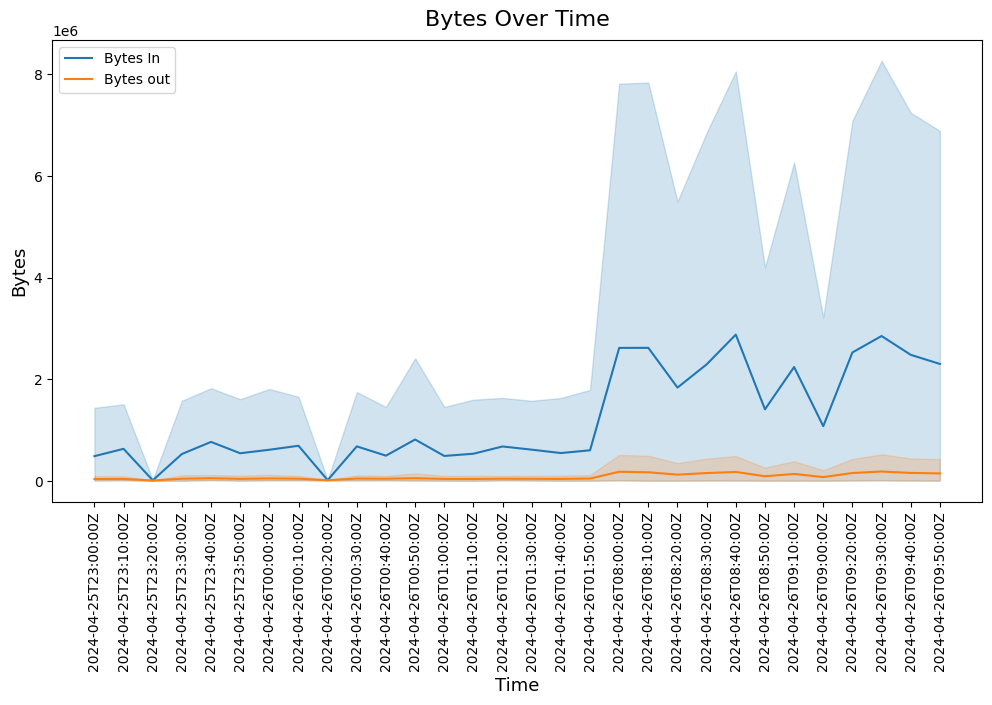

In [ ]:
plt.figure(figsize=(12, 6))
sb.lineplot(x='st',y='bytes_in',data=data, label='Bytes In')
sb.lineplot(x='st',y='bytes_out',data=data, label='Bytes out')
plt.legend()
plt.title('Bytes Over Time',fontsize=16,pad=10)
plt.xlabel("Time",fontsize=13)
plt.ylabel("Bytes",fontsize=13)
plt.xticks(rotation=90)
plt.savefig('Outputs/Bytes Over Time.png')
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13152\3652825281.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='label', y='Packet Size', data=sorted_data, errorbar=None,palette="viridis")


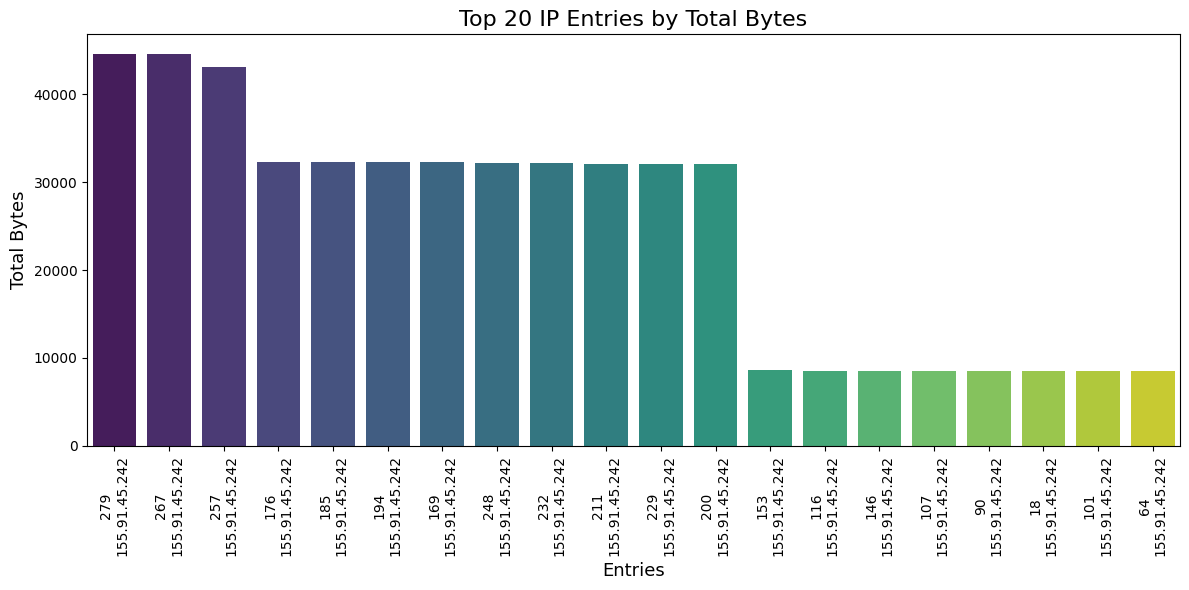

In [175]:
sorted_data = data.sort_values(by='Packet Size', ascending=False).head(20)
sorted_data['label'] = sorted_data.index.astype(str) + '\n' + sorted_data['src_ip']  # Create unique x-axis labels

plt.figure(figsize=(12,6))
sb.barplot(x='label', y='Packet Size', data=sorted_data, errorbar=None,palette="viridis")

plt.xticks(rotation=90)
plt.title('Top 20 IP Entries by Total Bytes', fontsize=16)
plt.xlabel("Entries", fontsize=13)
plt.ylabel("Total Bytes", fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top_20_IP_Entries_by_Total_Bytes.png')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13152\616805734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")


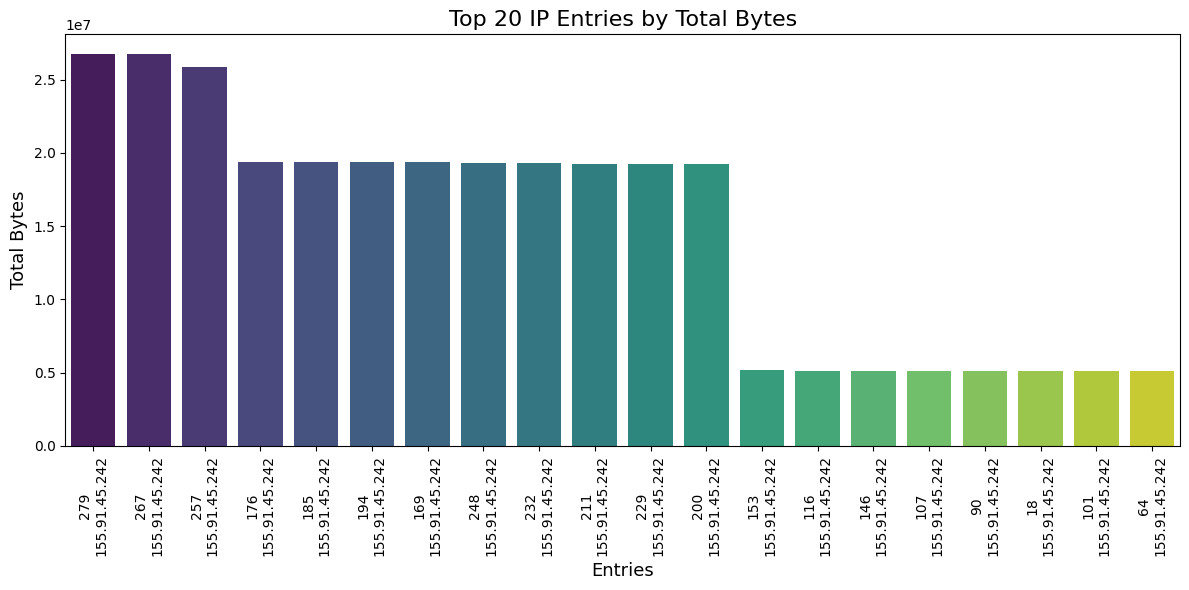

In [176]:
sorted_data = data.sort_values(by='Total Bytes', ascending=False).head(20)
sorted_data['label'] = sorted_data.index.astype(str) + '\n' + sorted_data['src_ip']  # Create unique x-axis labels

plt.figure(figsize=(12,6))
sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")

plt.xticks(rotation=90)
plt.title('Top 20 IP Entries by Total Bytes', fontsize=16)
plt.xlabel("Entries", fontsize=13)
plt.ylabel("Total Bytes", fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top_20_IP_Entries_by_Total_Bytes.png')
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13152\305967987.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")


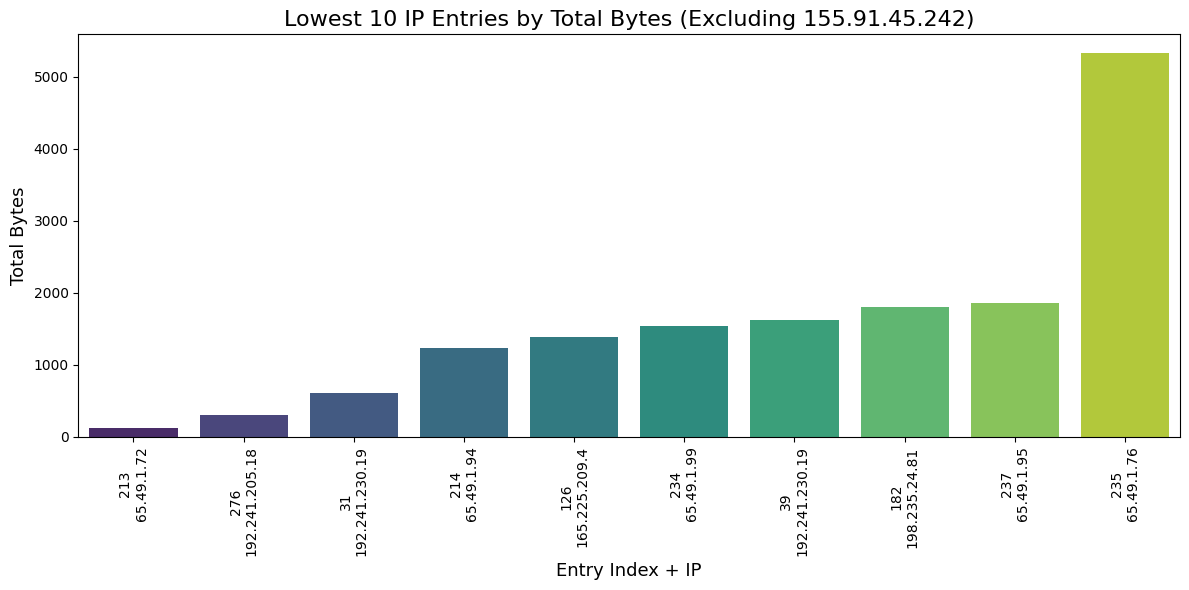

In [177]:
# Exclude the dominant IP
filtered_data = data[data['src_ip'] != '155.91.45.242']
# Sort and take top 10 entries by Total Bytes
sorted_data = filtered_data.sort_values(by='Total Bytes').head(10)
# Create unique x-axis labels (Index + IP)
sorted_data['label'] = sorted_data.index.astype(str) + '\n' + sorted_data['src_ip']
# Plot
plt.figure(figsize=(12,6))
sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")

plt.xticks(rotation=90)
plt.title('Lowest 10 IP Entries by Total Bytes (Excluding 155.91.45.242)', fontsize=16)
plt.xlabel("Entry Index + IP", fontsize=13)
plt.ylabel("Total Bytes", fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Lowest_10_IP_Entries_Excluding_155.91.45.242.png')
plt.show()


In [ ]:

# Create a basic world map
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Get unique countries (drop duplicates and NaN)
unique_countries = data[['src_ip_country_code']].dropna().drop_duplicates()

# Approximate centroids for countries

geolocator = Nominatim(user_agent="geoapi")

# Dictionary to cache lat/lon for country codes
country_coords = {}

for code in unique_countries['src_ip_country_code']:
    try:
        # Get country name from ISO Alpha-2 code
        country_name = countries.get(code).name
        location = geolocator.geocode(country_name)
        if location:
            country_coords[code] = (location.latitude, location.longitude)
            # Add marker
            folium.CircleMarker(
                location=(location.latitude, location.longitude),
                radius=5,
                popup=f"{code} - {country_name}",
                color='blue',
                fill=True,
                fill_opacity=0.6
            ).add_to(world_map)
        sleep(1)  # avoid hitting API rate limits
    except:
        pass  # skip invalid codes

# Save to HTML
world_map.save("Outputs/source_ip_folium_map.html")


In [ ]:
data['src_ip_country_code'].unique()

array(['AE', 'US', 'CA', 'NL', 'DE', 'AT', 'IL'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

In [ ]:
data['is_malicious'] = data['rule_names'].apply(lambda x: 1 if 'Suspicious' in x else 0)


features = data[['bytes_in', 'bytes_out', 'protocol', 'src_ip_country_code','Packet Size', 'response.code','Total Bytes', 'dst_port','Duration']]
features = pd.get_dummies(features, drop_first=True)


X = features
y = data['is_malicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



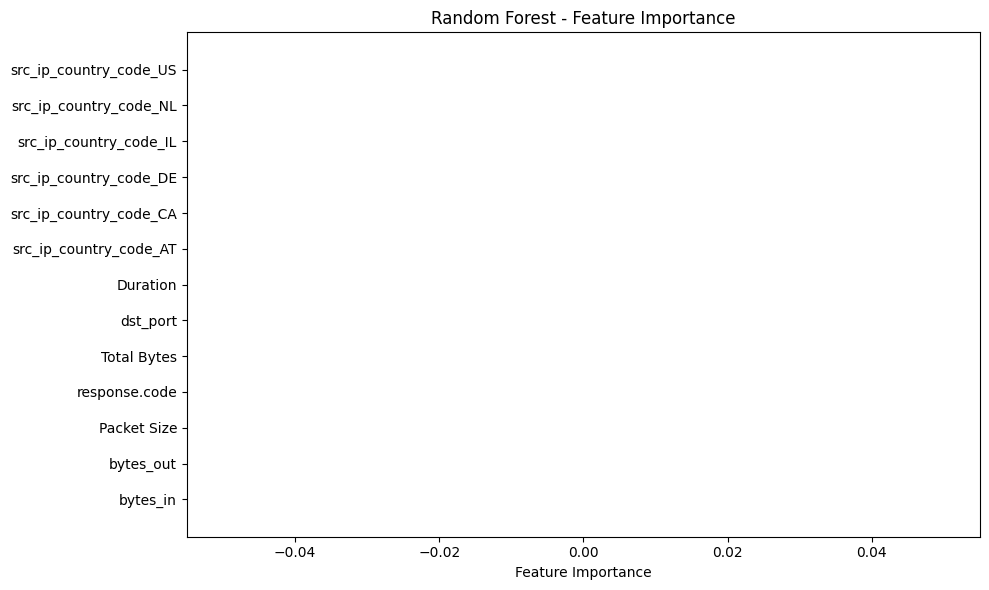

In [ ]:
importances = model.feature_importances_
feature_names = X.columns

# Sort the importances
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.show()

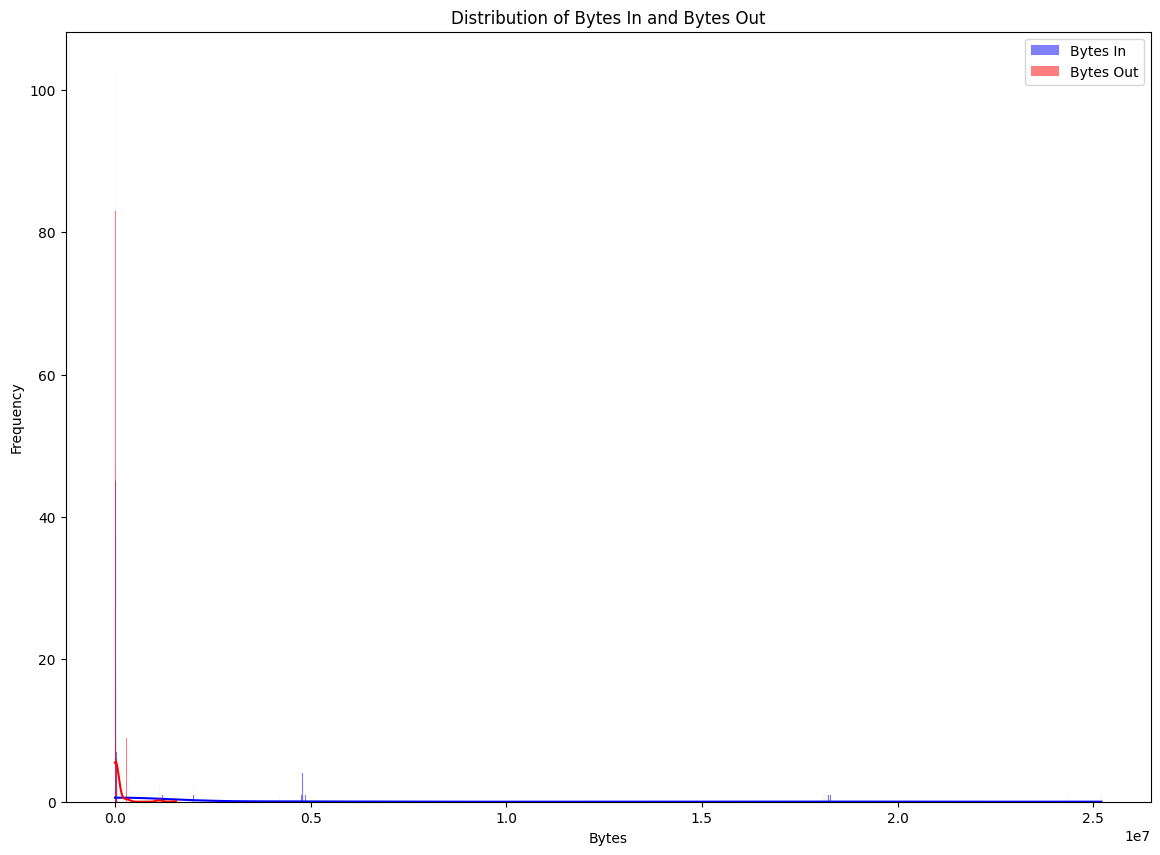

In [ ]:
# Visualize bytes_in and bytes_out distribution
plt.figure(figsize=(14, 10))
sb.histplot(data['bytes_in'], kde=True, color='blue', label='Bytes In')
sb.histplot(data['bytes_out'], kde=True, color='red', label='Bytes Out')
plt.xlabel('Bytes')
plt.ylabel('Frequency')
plt.title('Distribution of Bytes In and Bytes Out')
plt.legend()
plt.show()